In [1]:
# Create the correlation summary tables

In [2]:
!date
!pwd

Tue Jul  5 20:07:13 PDT 2022
/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis


In [3]:
import os
import sys
import pickle
import datetime
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from matplotlib.colors import ListedColormap
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis/../tools/common.py'>

In [6]:
table = common.CorrTable(control)
table.apply_filters(metrics=["Corr","Delta"], replace_with_nan=False)
comp_cols = [f for f in table.comparisons.keys()]
table.cluster(cols=comp_cols, thresh=0.05, show=False)
df, columns = table.get_df(group=None, remove_symm=False, return_col_names=True)
# Find names of columns we want to set style for
# Assumes columns are ordered in the same way for
# all combinations
comp_cols, corr_cols, delta_cols, swap_cols = columns

### Stereotypy heatmaps

In [7]:
df_stereo = df.loc[df.S1==df.S2]
df_stereo = df_stereo.drop(columns=["S2"])
df_stereo.index = df_stereo["S1"]
df_stereo.columns.name = "Conditions"
df_stereo = df_stereo.loc[control.get_gene_names()]
common.save_html_table(df_stereo, columns, table, "table_stereo.html")

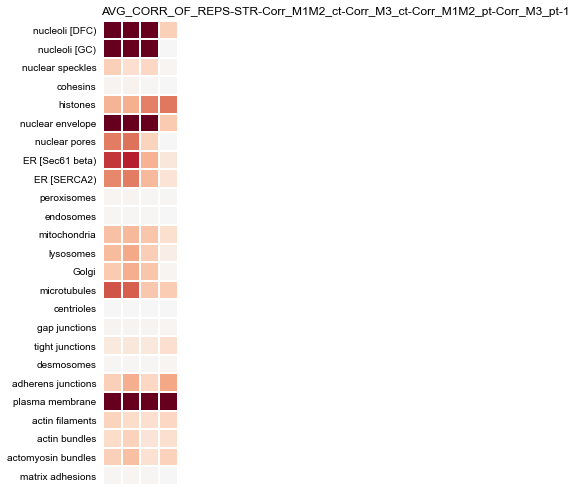

In [8]:
# Heatmap for correlation values
importlib.reload(plotting)
row = pd.Series({"shape_mode": "-".join(corr_cols), "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.set_heatmap_min_max_values(-0.2, 0.2)
ploter.make_heatmap(df_stereo[corr_cols], display=True)
ploter.figs[0][0].savefig(f"FigureMitosis3_corrs.pdf")

'AVG_CORR_OF_REPS-STR-Corr_M1M2_ct-Corr_M3_ct-Corr_M1M2_pt-Corr_M3_pt-1'

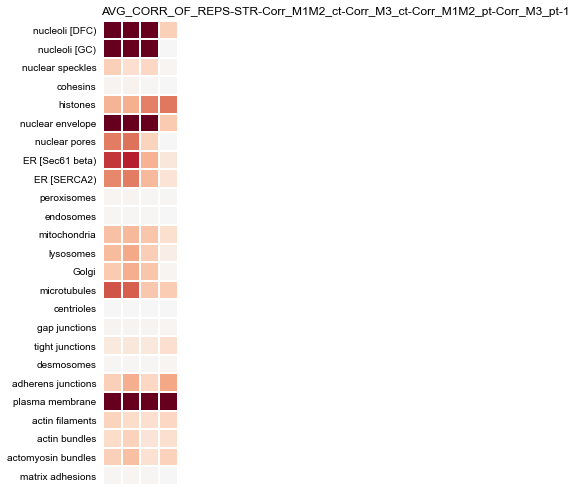

In [9]:
# Heatmap for correlation values
importlib.reload(plotting)
row = pd.Series({"shape_mode": "-".join(corr_cols), "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.set_heatmap_min_max_values(-0.2, 0.2)
ploter.make_heatmap(df_stereo[corr_cols], display=True)

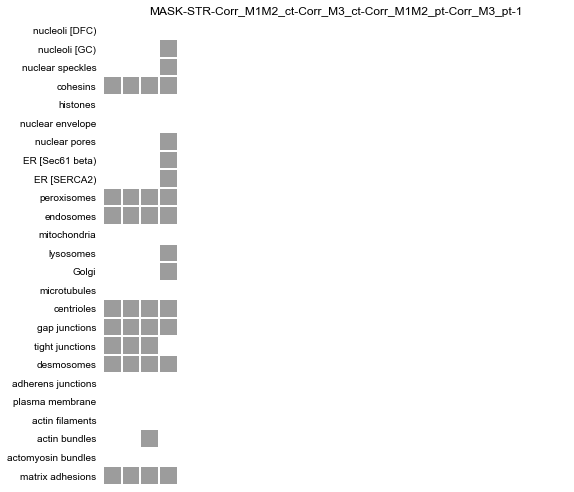

In [10]:
# Heatmap for correlation values
importlib.reload(plotting)
row = pd.Series({"shape_mode": "-".join(corr_cols), "mpId": 1, "aggtype": "MASK", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)

colors = [
    (255,255,255,0),
    (100,100,100,1)
]
cmap = ListedColormap(colors[::-1])
cmap.set_under(color="white", alpha="0")
ploter.make_heatmap((df_stereo[corr_cols].abs()<table.filters["Corr"][-1]).astype(int), cmap=cmap, display=True)
ploter.figs[0][0].savefig(f"FigureMitosis3_corrs_mask.pdf", transparent=True)

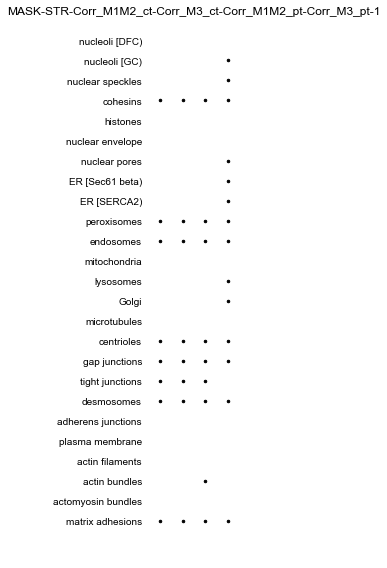

In [11]:
mask_stereo = (df_stereo[corr_cols].abs()<table.filters["Corr"][-1]).astype(int)
row = pd.Series({"shape_mode": "-".join(corr_cols), "mpId": 1, "aggtype": "MASK", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(mask_stereo, mask_stereo, colors={0: (0,0,0)}, size_scale=25, display=True, dotted=[1], xlim=(-0.5, 3.5))
ploter.figs[0][0].savefig(f"FigureMitosis3_corrs_mask.pdf", transparent=True)

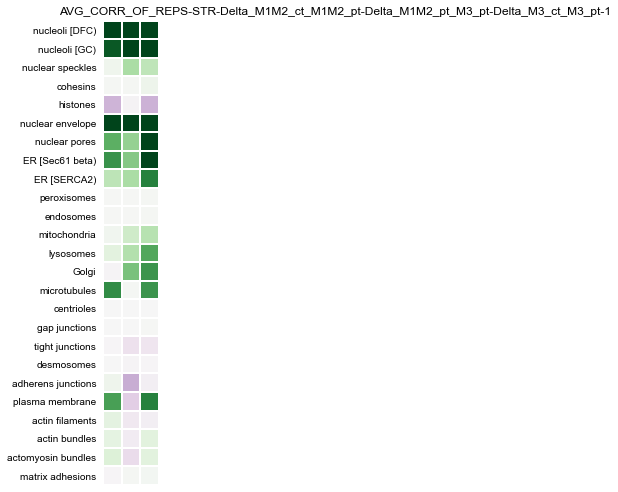

In [12]:
# Heatmap for differences
importlib.reload(plotting)
row = pd.Series({"shape_mode": "-".join(delta_cols), "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.set_heatmap_min_max_values(-0.1, 0.1)
ploter.make_heatmap(-df_stereo[delta_cols], cmap="PRGn", display=True)
ploter.figs[0][0].savefig(f"FigureMitosis3_deltas.pdf")

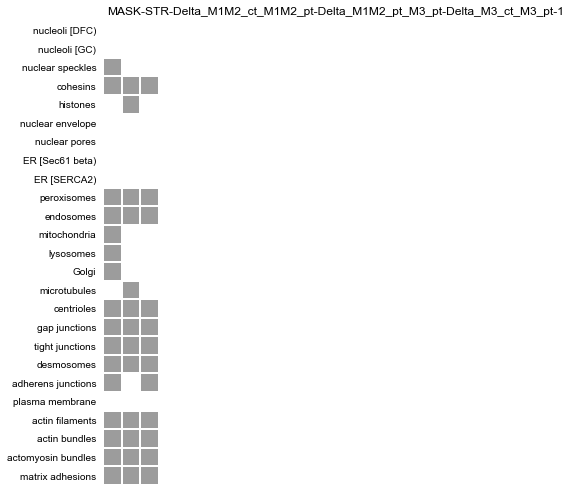

In [13]:
# Heatmap for delta values
importlib.reload(plotting)
row = pd.Series({"shape_mode": "-".join(delta_cols), "mpId": 1, "aggtype": "MASK", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
colors = [
    (255,255,255,0),
    (100,100,100,1)
]
cmap = ListedColormap(colors[::-1])
cmap.set_under(color="white", alpha="0")
ploter.make_heatmap((df_stereo[delta_cols].abs()<table.filters["Delta"][-1]).astype(int), cmap=cmap, display=True)
ploter.figs[0][0].savefig(f"FigureMitosis3_deltas_mask.pdf", transparent=True)

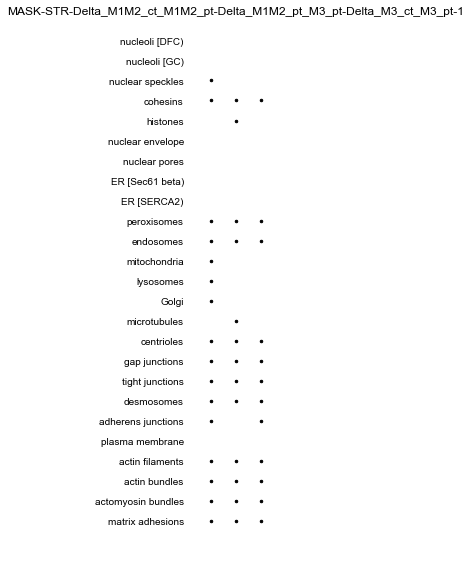

In [14]:
mask_stereo_dif = (df_stereo[delta_cols].abs()<table.filters["Delta"][-1]).astype(int)
row = pd.Series({"shape_mode": "-".join(delta_cols), "mpId": 1, "aggtype": "MASK", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(mask_stereo_dif, mask_stereo_dif, colors={0: (0,0,0)}, size_scale=25, display=True, dotted=[1], xlim=(-0.8, 2.8))
ploter.figs[0][0].savefig(f"FigureMitosis3_deltas_mask.pdf", transparent=True)

### Concordance

In [15]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis/../tools/common.py'>

In [16]:
# Creating the color coded table for figure mitotic
mxs, sws = [], []
for comp_col, swap_col in zip(comp_cols, swap_cols):
    mx = df.set_index(["S1","S2"], drop=True)[comp_col].unstack(level="S2")
    sw = df.set_index(["S1","S2"], drop=True)[swap_col].unstack(level="S2")
    mxs.append(mx.values)
    sws.append(sw.values)
mxs = np.array(mxs)
sws = np.array(sws)

In [17]:
importlib.reload(common)
masker = common.Masker(control)
masker.set_data(mxs, sws)
masker.execute()
df1, df2, cmap = masker.get_result_as_dataframes_and_cmap(ignore_confidence=True)
for c in df2.columns:
    df2.loc[df1[c].isin([5,6,7,8]), c] = 3

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis/../tools/common.py:462: RuntimeWarning: All-NaN slice encountered
  levels = np.nanmin(levels, axis=0)


In [18]:
df1.at["AAVS1", "AAVS1"] = 1

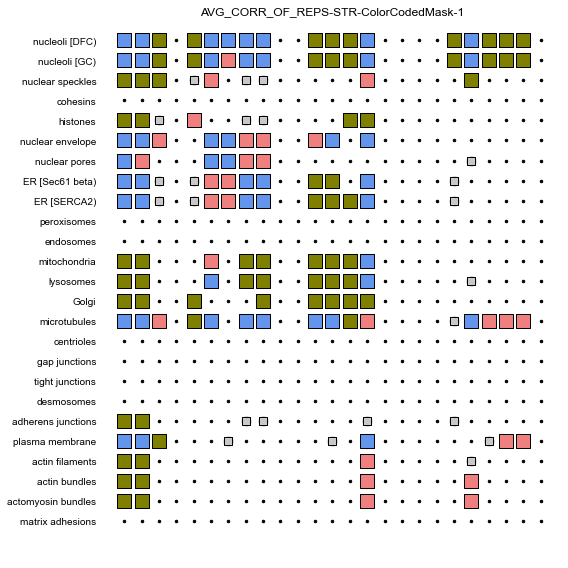

In [19]:
importlib.reload(plotting)
row = pd.Series({"shape_mode": "ColorCodedMask", "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df1, df2, colors=cmap, size_scale=25, display=True, dotted=[1])
ploter.figs[0][0].savefig(f"FigureMitosis3_flag_conco.pdf", transparent=True)

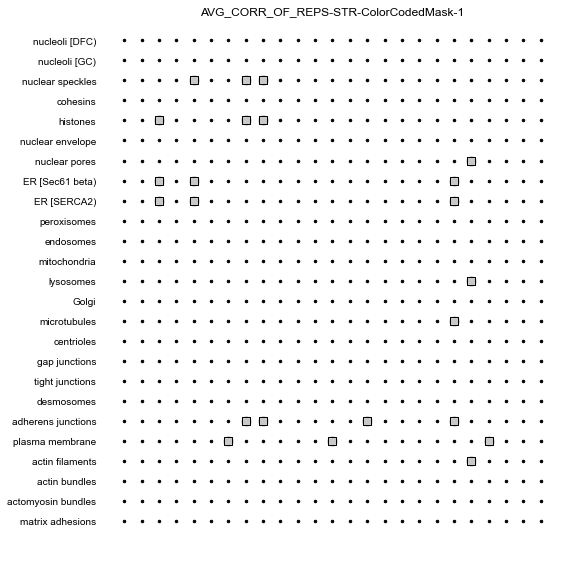

In [20]:
importlib.reload(plotting)
row = pd.Series({"shape_mode": "ColorCodedMask", "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df1, df2, colors=cmap, size_scale=25, display=True, dotted=[1,2,3,4])
ploter.figs[0][0].savefig(f"FigureMitosis3_flag_conco_grid.pdf", transparent=True)

In [21]:
df_conco_sig = []
for col in corr_cols[:-1]:
    msk = df[["S1","S2"]+corr_cols].pivot_table(col, 'S1', 'S2').abs()<0.03
    df_conco_sig.append(msk)
df_conco_sig = pd.DataFrame(np.array(df_conco_sig).sum(axis=0), index=df1.index, columns=df1.columns)
cmap_sig = {0:(1,1,1,1), 1:(1,1,1,1), 2:(1,1,1,1), 3:(1,1,1,1)}

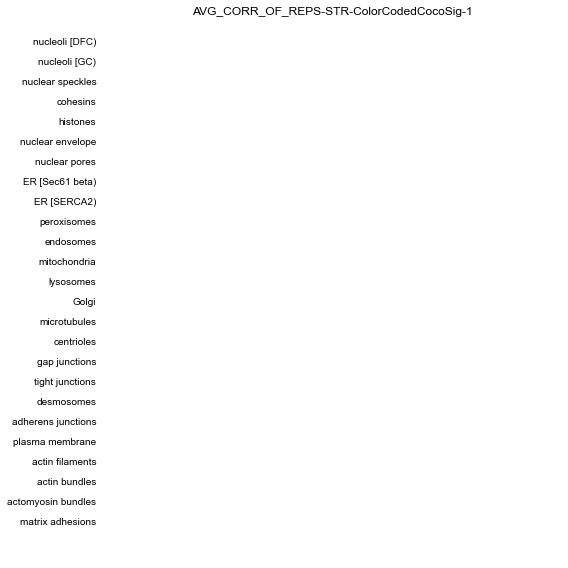

In [22]:
importlib.reload(plotting)
row = pd.Series({"shape_mode": "ColorCodedCocoSig", "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df_conco_sig, df2, colors=cmap_sig, size_scale=32, display=True, hide=[0,1,2], ec_on=False, background_dot=False)
ploter.figs[0][0].savefig(f"FigureMitosis3_flag_concosig.pdf", transparent=True)

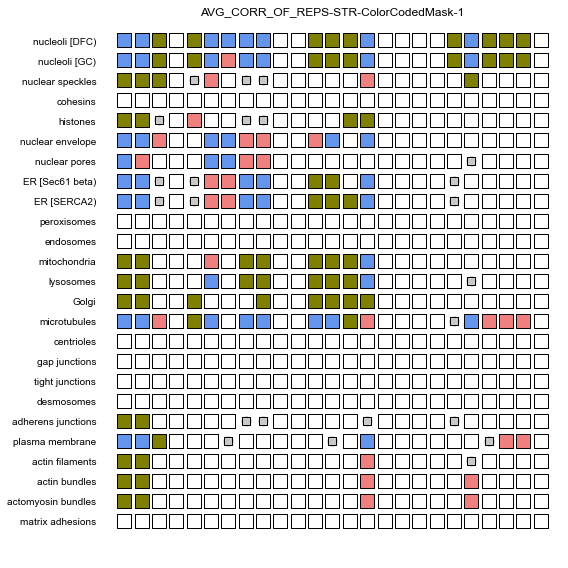

In [23]:
row = pd.Series({"shape_mode": "ColorCodedMask", "mpId": 1, "aggtype": "AVG_CORR_OF_REPS", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df1, df2, colors=cmap, size_scale=25, display=True, hide_colors=[1])
ploter.figs[0][0].savefig(f"FigureMitosis3_flag_conco.pdf", transparent=True)

In [24]:
df1.to_csv("mask1.csv")
df2.to_csv("mask2.csv")
with open("cmap.pkl", "wb") as fp:
    pickle.dump(cmap, fp)

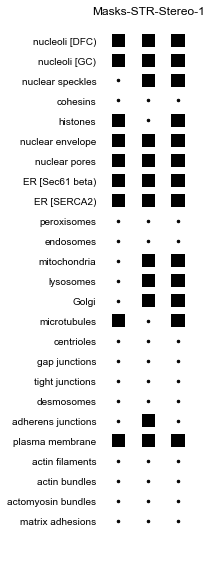

In [25]:
importlib.reload(plotting)

masker = common.Masker(control)
masker.set_data(common.Masker.reduce_to_diag(mxs), common.Masker.reduce_to_diag(sws), colnames=["A", "B", "C"])
masker.execute()
df1, df2, cmap = masker.get_result_as_dataframes_and_cmap(ignore_confidence=True)

row = pd.Series({"shape_mode": "Stereo", "mpId": 1, "aggtype": "Masks", "alias": "STR"}, name=0)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df1, df2, colors={8: (0,0,0)}, size_scale=25, display=True, dotted=[7], ec_on=False, background_dot=False, xlim=(-0.5, 2.5))
ploter.figs[0][0].savefig(f"FigureMitosis3_masks_stereo.pdf", transparent=True)

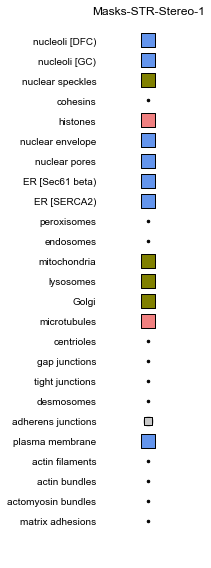

In [26]:
masker = common.Masker(control)
masker.set_data(common.Masker.reduce_to_diag(mxs, True), common.Masker.reduce_to_diag(sws, True), colnames=["S"])
masker.execute()
df1, df2, cmap = masker.get_result_as_dataframes_and_cmap(ignore_confidence=True)
df2.loc[df1.S==6, "S"] = 3

importlib.reload(plotting)
ploter = plotting.ConcordancePlotMaker(control)
ploter.set_row(row)
ploter.make_confidence_heatmap(df1, df2, colors=cmap, size_scale=25, display=True, dotted=[1], xlim=(-0.5, 0.5))
ploter.figs[0][0].savefig(f"FigureMitosis3_flag_stereo.pdf", transparent=True)

In [27]:
common.now("complete")

complete 2022-07-05 20:07:57
